In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import math
import pickle
import cv2  
from skimage.measure import block_reduce
import scipy.ndimage as ndi
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.colors
from skimage.transform import resize
from matplotlib.patches import Ellipse
from matplotlib.ticker import FuncFormatter
from sklearn import metrics

In [2]:
# Global variables

# Make sure paths, filenames and survey resolutions are correct for your machine and data
data_dir = os.path.join(os.getcwd(),"data") 

survey_file = 'synth.pkl'             # uncomment to run on synth data
# pixel_dist is the real world distance, in meters, represented by a single pixel
pixel_dist = 0.1  #(m)                # uncomment to run on synth data

# survey_file = 'benchmark.pkl'            # uncomment to run on real data
# pixel_dist = 0.2  #(m)                   # uncomment to run on real data

target_file = survey_file[:-3]+'txt'
result_dir = os.path.join(os.getcwd(),"results")

In [3]:
# These parameters should not usually be altered. If you experience memory issues, lower linkage_limit.

threshold = 1.5 # Winsorize readings more than this many standard deviations from the mean
linkage_method = 'single' # Distance metric used by initial hierarchical clustering
CH_step = 3 # X axis step size for computing the CH curve
max_cluster_size = 20  # In meters; clusters above this size are split

linkage_limit = 30000  # Split survey into batches if number of points to cluster exceeds this amount

In [4]:
def get_compression():
    """
    We compress the image for faster analysis, but ensure that the resolution does not drop below 0.5m.
    
    returns:
        int compression:  factor for image compression
    """
    min_resolution = 0.5
    compression = math.floor(min_resolution/pixel_dist)
    return compression if compression >= 1 else 1

In [5]:
def prepare_result_dir():
    """
    We create separate directories for the storage of intermediate results.
    """
    directories = ('', 'linkage', 'CH_score', 'times', 'coords', 'im_wo_processing', 'survey_im', 'target_im', 'score')
    for directory in directories:
        isExist = os.path.exists(os.path.join(result_dir,directory))
        if not isExist:
            os.makedirs(os.path.join(result_dir,directory))
    
    # Record the time taken by various computations.
    times = 'load_data_time, linkage_time, CH_plot_time, cluster_division_time, inversion_select_time'
    with open(os.path.join(result_dir,"times","headers.txt"), 'w') as f:
        f.write(times)

In [6]:
prepare_result_dir()

In [7]:
def load_data(survey_path):
    """
    Loads in a survey file and performs preprocessing.
    Saves plots of the before and after.
    
    params:
        str survey_path: path to survey data, a pickled np array gridded in 2d with at least 1 data channel
    
    returns:
        np array survey: processed survey data
        int area: pixel count of non NaN values, representing the area of the survey
        np array survey_mask: binary array indicating the inbounds survey area after the border is cropped
    """
    
    survey_im = pickle.load(open(survey_path, 'rb'))
    h, w = survey_im.shape[1:]
    
    # Winsorize and scale.
    for i in range(3):
        lower_q, higher_q = np.nanquantile(survey_im[i], (0.05, 0.95))
        survey_im[i] = (survey_im[i] - lower_q) / (higher_q - lower_q)     
    survey_im = survey_im.clip(0,1)
    
    # Save winsorized and scaled images.
    f = os.path.join(result_dir,"im_wo_processing",survey_file)
    pickle.dump(survey_im, open(f, 'wb')) 
    
    # Crop the boundary of survey to improve stability at the boundary.    
    # Note: PIL and cv2 use w, h ordering as opposed to h, w as per np
    not_nan = ~np.isnan(survey_im[0])
    img = not_nan.astype(np.uint8)*255
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closed_image = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

    # Select largest contour in case of disjoint survey data.
    # Note that contour cntr is not evenly sampled; may have gaps between points when perimeter is 'flat'.
    contours = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    max_size = 0
    for i in range(len(contours)):
        if contours[i].size > max_size:
            cntr = contours[i].reshape(-1,2)  # Reshape to single channel for mask.
            max_size = contours[i].size

    survey_mask = Image.new('1', (w, h), 0)
    draw = ImageDraw.Draw(survey_mask)
    draw.polygon([(x, y) for x, y in cntr], outline=1, fill=1)
    survey_mask = np.array(survey_mask)

    # Upsample to ensure good resolution for cropping (2 pixel limit).
    upsampled = []
    d = 2
    for i in range(cntr.shape[0]-1):
        p1 = cntr[i]
        p2 = cntr[i+1]
        
        dist = np.linalg.norm(p2 - p1)
        if dist > d :
            num_points = int(np.ceil(dist / d))
            delta = (p2 - p1) / num_points  

            for j in range(num_points):
                x,y = p1 + (j + 1) * delta
                upsampled.append([math.floor(x), math.floor(y)])
        upsampled.append(p2)
            
    # Crop 1 meter from the perimeter of the survey.
    crop = math.ceil(1/(pixel_dist*get_compression()))
    for x,y in upsampled:
        x1 = x - crop if x - crop > 0 else 0
        x2 = x + crop if x + crop < w else w-1
        y1 = y - crop if y - crop > 0 else 0
        y2 = y + crop if y + crop < h else h-1
        
        survey_mask[y1:y2+1,x1:x2+1] = 0 # h, w ordering for np
    survey = np.zeros(survey_im.shape)
    
    for i in range(3):
        survey[i] = survey_im[i]
        survey[i][np.where((survey_mask == 0))] = np.nan
  
    
    # Compress.
    scaled = block_reduce(survey, block_size=(1,get_compression(),get_compression()), func=np.nanmean)
    # Set the final row and col to nan - otherwise, block reduce function may incorrectly produce zeroes.
    scaled[:,-1] = np.nan
    scaled[:,:,-1] = np.nan
    h,w = scaled.shape[1:]

    # Z-score.
    for i in range(3):
        std = np.nanstd(scaled[i])
        mean = np.nanmean(scaled[i])
        scaled[i] =  (scaled[i]-mean) * 1/std
    

    # Fill nans.
    for i in range (3):
        nans = np.isnan(scaled[i])
        scaled[i][nans] = np.nanmean(scaled[i])
    
    # Calculate survey area.
    area = w*h-np.count_nonzero(nans)
    

    # Blur to reduce noise.
    size = 2
    mean_kernel = np.full((size,size),1/(size**2))
    for i in range(3):
        scaled[i] = ndi.correlate(scaled[i], mean_kernel)
    
    
    # Save fully processed images.
    f = os.path.join(result_dir,"survey_im",survey_file)
    pickle.dump(scaled, open(f, 'wb'))
    
    return scaled, area, survey_mask

In [8]:
def cluster_survey(survey_path):
    """
    Perform the filtering and clustering on a survey.
    If survey is larger than the limit, we split into batches.
    Each batch is clustered independently, producing numbered linkage matrices. 
    
    params:
        str survey_path: path to pickled np array gridded in 2d with at least 1 data channel
    
    returns:
        str suffix: empty string if survey was not split into batches;
                    otherwise the string respresenting the total number of files in the created batches
    
    """
    
    load_start_time = time.time()
    survey, area, inbounds_mask = load_data(survey_path)
    i,h,w = survey.shape
    mask = np.zeros((h,w))
    mask[np.where(((survey > threshold) | (survey < -threshold)).any(axis=0))]  = 1
    coords = np.array(np.nonzero(mask)).T
    
    # Cap number of clusters so that 10m by 10m inversions cover the survey. 
    max_clusters = int(round((area)/(10/(pixel_dist*get_compression()))**2))
    if max_clusters < 10:
        max_clusters = 10
    
    load_end_time = time.time()
    cumulative_linkage_time = 0
    cumulative_CH_plot_time = 0

    suffix = ''
    batches = [coords]
    while not len(batches[0])<linkage_limit:
        new_batches = []
        for batch in batches:
            new_batches.extend(np.array_split(batch,3))
        batches = new_batches   

    clusters = int(round(2*max_clusters/len(batches))/2)
    # If clustering directly would take too much memory, we split to smaller batches.
    for n, batch in enumerate(batches):
        if n > 0:
            suffix = str(n)

        linkage_time, CH_plot_time = compute_clustering(batch, clusters, suffix)
        cumulative_linkage_time += linkage_time
        cumulative_CH_plot_time += CH_plot_time  

        with open(os.path.join(result_dir, "times", target_file), 'w') as f:
            f.write(str(load_end_time-load_start_time)+", "+str(cumulative_linkage_time)+", "+str(cumulative_CH_plot_time))
    
    return suffix, inbounds_mask

In [9]:
def compute_clustering(coords, max_clusters, suffix = ''):
    """
    Helper. Performs clustering, computes CH scores, and saves intermediate results. 
    
    params:
        str survey_path: path to pickled np array gridded in 2d with at least 1 data channel
    
    returns:
        str suffix: empty string if survey was not split into batches;
                    otherwise the string respresenting the total number of files in the created batches
    """
    f = os.path.join(result_dir,"coords",survey_file[:-4]+suffix+".pkl")
    pickle.dump(coords, open(f, 'wb'))
    
    # Hierarchical clustering.
    make_linkage_start_time =time.time()
    linkage_mat = linkage(coords, method=linkage_method)
    f = os.path.join(result_dir,"linkage",survey_file[:-4]+suffix+".pkl")
    pickle.dump(linkage_mat, open(f, 'wb'))

    CH_plot_start_time = time.time()
    
    # Create the CH plot used later to choose the number of clusters based on 'knee' point.
    # CH_step is a hyperparameter - bigger step decreases runtime and plot resolution.
    n_clusters = [x for x in range(2, max_clusters, CH_step)]
    CH_score = []

    for i, n in enumerate(n_clusters):
        labels = fcluster(linkage_mat, n, criterion='maxclust')
        # Handle single cluster edge case.
        if i == 0 and len(set(linkage_mat[:,2])) == 1:
            print("single cluster formed")
            break
        if len(set(labels)) < 2:
            CH_score.append(0)
        else:
            CH_score.append(metrics.calinski_harabasz_score(coords, labels))

    f = os.path.join(result_dir,"CH_score",survey_file[:-4]+suffix+".pkl")
    pickle.dump(CH_score, open(f, 'wb'))
    
    CH_plot_end_time = time.time()
    
    linkage_time = CH_plot_start_time - make_linkage_start_time 
    CH_plot_time = CH_plot_end_time - CH_plot_start_time

    return linkage_time, CH_plot_time

In [11]:
def pick_n_clusters(n_clusters, model):
    """
    Find the CH plot 'knee' point to choose the number of clusters.
    This is the point with maximum vertical distance from the line connecting the first and last points.
    
    params:
        list n_clusters:  the x coordinates of the CH plot, determined by the hyperparameter CH_step
        np poly1d model:  a fitted model which returns the corresponding y coordinate
    
    returns:
        int:  the number of clusters at the CH plot 'knee' point
    """
    x, y = np.array(n_clusters), np.array(model(n_clusters))
    
    m = (y[-1] - y[0]) / (x[-1] - x[0])
    c = y[0] - m*(x[0]-0)
    line = m * x + c
    res = y - line
    midx = np.argmax(np.abs(res))
    
    return x[midx]

In [12]:
def to_codebook(X, part):
    """
    Helper. Find centroids of a series of clusters.
    
    params:
        arraylike X: list of coordinates
        arraylike part: list of the cluster index each coordinate belongs to
    
    returns:
        np array codebook: list of cluster centroids    
    """
    
    if X.size == 0:
        return []
    
    codebook = []
    
    for i in range(part.min(), part.max()+1):
        codebook.append(X[part == i].mean(0))

    return np.vstack(codebook)

def is_cluster_big(coords):
    """
    Helper. Determine whether a cluster exceeds max_cluster_size.
    
    params:
        arraylike coords:  list of coordinates of a single cluster.
        
    returns:
        boolean:  whether cluster exceeds max_cluster_size.
    """
    y_max = np.amax(coords[:,1])
    y_min = np.amin(coords[:,1])
    x_max = np.amax(coords[:,0])
    x_min = np.amin(coords[:,0])
    dx = x_max-x_min
    dy = y_max-y_min

    if dx*(pixel_dist*get_compression()) > max_cluster_size or dy*(pixel_dist*get_compression()) > max_cluster_size:
        return (dx, dy)
    
    return False

def divide(coords):
    """
    Helper. Continuously divide large clusters until each new cluster is of appropriate size.
    
    params:
        arraylike coords:  list of coordinates of a single cluster.
        
    returns:
        list clusters:  list of appropriately sized cluster(s).
    """
    clusters = []
    
    if is_cluster_big(coords):
        # Break down large clusters by clustering further with Ward distance metric.
        linkage_mat = linkage(coords, method='ward') 
        new_clusters = fcluster(linkage_mat, 2, criterion='maxclust')
        if max(new_clusters)==1:
            clusters.append(coords)
            print("clustering breakdown failed")
            plt.figure()
            plt.scatter(coords[:,1], coords[:,0])
            plt.show()
            return clusters
        
        for c in range(1, 3):
            cluster = coords[np.where(new_clusters==c)]
            # Recursive call for extra large clusters.
            for x in divide(cluster):
                clusters.append(x)
     
    else:
        clusters.append(coords)
               
    return clusters

def get_centroids(coords, colors): 
    """
    Helper. Divide clusters whose size exceeds max_cluster_size.
    Return the new clustering and centroids. 
    
    params:
        arraylike coords: list of coordinates
        arraylike colors: list of the cluster index each coordinate belongs to
    
    returns:
        np array new_centroids:  list of centroids of new clusters
        np array new_colors:  list of labels of new clusters
    """
    if colors.size == 0:
        return np.array([]), np.array([])
    new_colors = np.array(colors, copy=True)  
    
    n_clusters = max(colors)
    n_added = 0

    for color in set(colors):
        cluster = coords[np.where(colors==color)]
        sub_clusters = divide(cluster)
        for sub_cluster in sub_clusters[1:]:
            new_colors[(sub_cluster[:,np.newaxis] == coords).all(axis=2).any(axis=0)]=n_clusters+1+n_added
            n_added += 1
            
    new_centroids = to_codebook(coords, new_colors)               
    return new_centroids, new_colors

In [15]:
def cluster_stitch_and_divide(fname, n_files):
    """    
    params:
        str fname: 
        int n_files: number of batches the original survey was split into.
    
    returns:
    """
    start_time = time.time()
    components = [fname]
    # surveys with large coords arrays that were split to speed up clustering have to be stitched back
    if n_files:
        components.extend([survey_file[:-4] + str(x) +'.pkl' for x in range(1,int(n_files)+1)])
    # save results in a special directory for the set max_cluster_size (a hyper parameter)
    directories = ['clusters'] + [os.path.join('clusters', str(max_cluster_size))]
    
    for directory in directories:
        isExist = os.path.exists(os.path.join(result_dir,directory))
        if not isExist:
            os.makedirs(os.path.join(result_dir,directory))
    
    clustering_fail = False
    all_coords_x = []
    all_coords_y = []
    all_clusters = []
    clusters_created = 0
    #stitch the components
    for component in components:
        #files are save and loaded in as needed to avoid excessive memory use
        linkage_f = os.path.join(result_dir,"linkage",component)
        linkage_mat = pickle.load(open(linkage_f, 'rb'))
        CH_score_f = os.path.join(result_dir,"CH_score",component)
        CH_score = pickle.load(open(CH_score_f, 'rb'))
        coords_f = os.path.join(result_dir,"coords",component)
        coords = pickle.load(open(coords_f, 'rb'))
        #step between calculated CH_scores is set as a hyper parameter
        n_clusters = [x for x in range(2,len(CH_score)*CH_step+2,CH_step)]
        

        if len(n_clusters) < 2:
            #Empty CH score array - single cluster formed
            clustering_fail = True
            clusters = np.ones(len(coords),dtype=int)
            print("empty CH score array")
        else:  
            model = np.poly1d(np.polyfit(n_clusters,CH_score, 4))
            # calculate and show knee/elbow
            knee_point = pick_n_clusters(n_clusters, model)
            clusters = fcluster(linkage_mat, knee_point, criterion='maxclust') + clusters_created

        Y,X = coords.T
        all_coords_x.extend(np.asarray(X))
        all_coords_y.extend(np.asarray(Y))
        all_clusters.extend((np.asarray(clusters)))
        clusters_created = np.max(all_clusters)

    all_coords = np.column_stack((all_coords_y,all_coords_x))
    original_centroids = to_codebook(all_coords, np.array(all_clusters))


    if not clustering_fail:
        centroids, colors = get_centroids(all_coords, np.array(all_clusters))        
    else:
        centroids, colors = np.array([]), np.array([])
    result = {    'coords':all_coords,
                  'colors':colors,
                  'original_colors': np.array(all_clusters),
                  'centroids':centroids,
                  'original_centroids':original_centroids}
    pickle.dump(result, open(os.path.join(result_dir,'clusters', str(max_cluster_size), fname),'wb'))

    times_path = os.path.join(result_dir, "times", target_file)
    with open(times_path, 'r') as f:
        line = f.read()
    combined = line + ", " + str(time.time()-start_time)
    with open(times_path, 'w') as f:
        f.write(combined)
    
    return result 

In [16]:
def MinVolEllipse(P, tolerance=0.05):
    """
    This code is adapted from an open source MATLAB implementation using the Khachiyan Algorithm:
    https://www.mathworks.com/matlabcentral/fileexchange/9542-minimum-volume-enclosing-ellipsoid?tab=reviews
    """
    # Solving the Dual problem
    P = P.T
    d, N = P.shape
    Q = np.zeros((d + 1, N))
    Q[:d, :] = P[:d, :N]
    Q[d, :] = 1

    # Initializations
    count = 1
    err = 1
    u = np.ones(N) / N  # 1st iteration

    # Khachiyan Algorithm
    while err > tolerance:
        X = Q @ np.diag(u) @ Q.T
        M = np.diag(Q.T @ np.linalg.inv(X) @ Q)
        j = np.argmax(M)
        maximum = M[j]
        step_size = (maximum - d - 1) / ((d + 1) * (maximum - 1))
        new_u = (1 - step_size) * u
        new_u[j] = new_u[j] + step_size
        count = count + 1
        err = np.linalg.norm(new_u - u)
        u = new_u

    # Computing the Ellipse parameters
    U = np.diag(u)

    # A matrix for the ellipse
    A = (1 / d) * np.linalg.inv(P @ U @ P.T - P @ u[:, None] @ (P @ u[:, None]).T)

    # Center of the ellipse
    c = (P @ u[:, None]).flatten()
    
    #Compute the covariance matrix
    cov_matrix = np.linalg.inv(A)

    # Extract the eigenvalues and eigenvectors of the covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Compute the semi-axis lengths (width and height)
    semi_axis_lengths = 2 * np.sqrt(eigvals)
    
    # Compute the angle of rotation (in degrees)
    angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])*180/math.pi

    return c, semi_axis_lengths, angle

In [17]:
def get_ellipse_coords(cy, cx, w, h, angle, shape, color=(0, 0, 255)):
    
    #set minimum inversion size to 3m^2
    min_size = 3 / (pixel_dist*get_compression())
    if w < min_size:
        w = min_size
    if h < min_size:
        h = min_size        
        
    image = np.zeros((shape[0], shape[1], 3), dtype=np.uint8)
    a = w / 2 
    b = h / 2
    center = (int(cx), int(cy))
    axes = (int(a), int(b))
    
    cv2.ellipse(image, center, axes, angle, 0, 360, color, -1)
    
    coords = np.argwhere(np.array(image/255)[:,:,2]==1)
    return coords

In [18]:
def elliptical_cluster_mask(inversion_list, shape):

    h,w = shape
    cluster_mask = np.zeros((h,w))
    
    for coords, seeds in inversion_list:
        cluster_mask[coords[:,0], coords[:,1]] = 1
        
        
    return cluster_mask

In [19]:
def list_elliptical_inversions(coords, colors, mask):
    start_time = time.time()
    inversions = []
    ellipses = []
    for color in set(colors):
        points = coords[np.where(dic['colors']==color)]
        try:
            # reminder: PIL and cv2 use w, h ordering as opposed to h, w as per np 
            # reverse points for consistent axis
            center, size, angle = MinVolEllipse(points[:, ::-1])
            if any(np.isnan(size)):
                raise Exception("Failed to fit ellipse ") 
                
        except:
            #singular matrix occurs if points are in strainght line, fit rectangle
            rect = cv2.minAreaRect(points[:, ::-1])
            center, size, angle = rect
        
        #restoring original scal
        center = np.array(center) * get_compression()
        size = np.array(size) * get_compression()
        cx,cy = center
        # add 3 m buffer (1.5 in each direction)
        w,h = np.array(size) + math.ceil(3 / (pixel_dist*get_compression()))
        ellipses.append((center, size, angle))
        
        if is_cluster_big(points):
            seeds, new_colors = get_centroids(points, color*np.ones((points.shape[0]), np.int8))
        else:
            seeds = np.array([[int(np.mean(points[:,0])),int(np.mean(points[:,1]))]])
    
        inversion_coords = get_ellipse_coords(cy, cx, w, h, angle, mask.shape)

        inbounds_mask = (inversion_coords[:, 0] >= 0) & (inversion_coords[:, 0] < mask.shape[0]) & (inversion_coords[:, 1] >= 0) & (inversion_coords[:, 1] < mask.shape[1]) & (mask[inversion_coords[:, 0],inversion_coords[:, 1]]) 
        inbounds = inversion_coords[inbounds_mask]
        
        inversions.append([inbounds,seeds])
        
    times_path = os.path.join(result_dir, "times", target_file)
    with open(times_path, 'r') as f:
        line = f.read()
    combined = line + ", " + str(time.time()-start_time)
    with open(times_path, 'w') as f:
        f.write(combined)
    
    return inversions, ellipses

# Run the code
the output is a list of tuples in the format [(coordinates_0, seeds_0), (coordinates_1, seeds_1)... ] where cordinates_0 is a list of the pixel cordinates that are inlcuded in the 0th proposed inversion and seeds_0 is a list of coordinates of initial guesses for the target center positions to be used in inversion (the center of the ellipse).


In [20]:
n_files, mask = cluster_survey(os.path.join(data_dir,"surveys",survey_file))
dic = cluster_stitch_and_divide(survey_file, n_files)
# original_colors uses non divided large clusters, colors uses divided
inversion_list, ellipses = list_elliptical_inversions(dic['coords'], dic['colors'], mask)
# uncomment the following line to toggle between breaking up big clusters and leaving intact
# inversion_list, ellipses = list_elliptical_inversions(dic['coords'], dic['original_colors'], mask)

/Users/clairemcginnity/.local/share/virtualenvs/inversion_proposal-6Fe6c1iP/lib/python3.7/site-packages/skimage/measure/block.py:90: RuntimeWarning: Mean of empty slice
  **func_kwargs)


# Visualize results

This part of the code is for analysis only - target file required 

In [21]:
def get_target_centroids(target_file, shape):
    
    targets = np.loadtxt(target_file).T
    h,w = shape 
    targetc = np.zeros((targets.shape[0],2),dtype=int)
    
    for i, t in enumerate(targets):
        x1, y1, x2, y2 = t
        xc = int(((x1 + x2)/2))
        yc = int(((y1 + y2)/2))
        
        if xc < 0:
            xc = 0
        if xc >= w:
            xc = w-1
        if yc < 0:
            yc = 0
        if yc >= h:
            yc = h-1
        
        targetc[i,0] = yc
        targetc[i,1] = xc
           
    return targetc

In [22]:
def get_score_dic(fname, inversion_list, mask):

    score_dic = {}

    target_file = os.path.join(data_dir,'targets',fname[:-4]+'.txt')
    targetc = get_target_centroids(target_file,mask.shape)
    
    cluster_mask = elliptical_cluster_mask(inversion_list, mask.shape)
    
    hit, missed, oob, accuracy = score(cluster_mask, targetc, mask)
    score_dic['hit'] = hit
    score_dic['oob'] = oob
    score_dic['missed']  = missed
    score_dic['accuracy'] = accuracy
    score_dic['mask'] = cluster_mask
    score_dic['inversions'] = inversion_list
    
    pickle.dump(score_dic, open(os.path.join(result_dir,'score', fname),'wb'))

    return score_dic

In [23]:
def score(cluster_mask, target_centroids, mask):
    hit = []
    missed = []
    oob = []
    
    for y,x in target_centroids:
        if not mask[y,x]:
            oob.append([y,x])
        elif cluster_mask[y,x]:
            hit.append([y,x])
        else:
            missed.append([y,x])
    
    n_hit = len(hit)
    accuracy = n_hit/(n_hit+len(missed))*100

    return np.array(hit), np.array(missed), np.array(oob), accuracy

In [24]:
score_dic = get_score_dic(survey_file, inversion_list, mask)

survey_f = os.path.join(result_dir,"im_wo_processing",survey_file)
survey = pickle.load(open(survey_f, 'rb'))

In [25]:
# convert plot ticks from in pixels to in meters
def format_plot_ticks(plt, pixel_dist):
    def format_ticks_helper(x, pos):
        scaled_x = x * pixel_dist
        return f"{scaled_x:.0f}"
    formatter_x = FuncFormatter(format_ticks_helper)
    formatter_y = FuncFormatter(format_ticks_helper)
    
    try: # for full figures
        plt.gca().xaxis.set_major_formatter(formatter_x)
        plt.gca().yaxis.set_major_formatter(formatter_y)
    except: # for subplot axes 
        plt.xaxis.set_major_formatter(formatter_x)
        plt.yaxis.set_major_formatter(formatter_y)

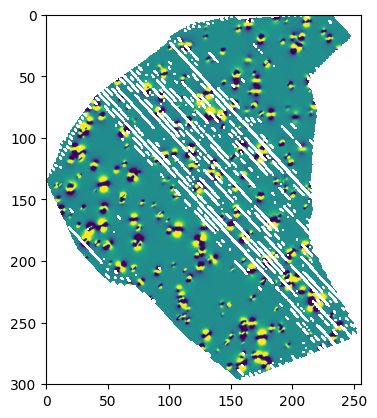

In [26]:
plt.figure()
format_plot_ticks(plt, pixel_dist)
plt.imshow(survey[0])

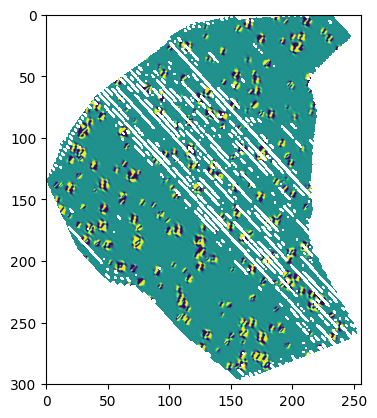

In [27]:
plt.figure()
format_plot_ticks(plt, pixel_dist)
plt.imshow(survey[1])

############################
n_inversions:  172
n_targets:  269
n_missed:  0
n_out_of_bounds 6


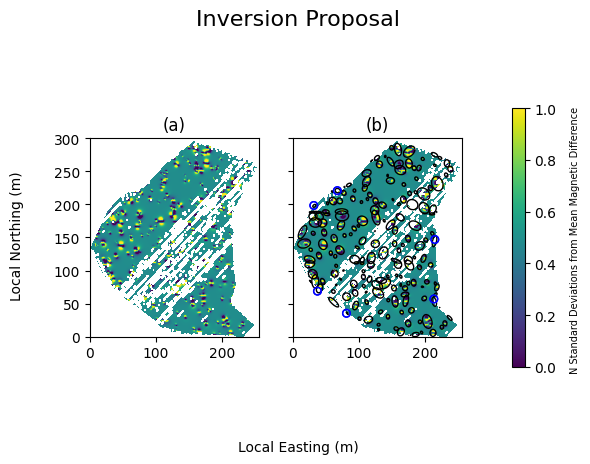

In [28]:
n_targets = len(np.loadtxt(os.path.join(data_dir,'targets',target_file)).T)
i,h,w = survey.shape

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
for ax in [ax1,ax2]:
    ax.imshow(survey[0])
    format_plot_ticks(ax, pixel_dist)
    ax.set_xlim(0, int(w))
    ax.set_ylim(0, int(h))
cbar = fig.colorbar(ax1.imshow(survey[0]), ax=[ax1, ax2], shrink=0.7, pad=0.1, location='right')
cbar.ax.set_ylabel('N Standard Deviations from Mean Magnetic Difference ', rotation=90,labelpad=10)
cbar.ax.yaxis.label.set_fontsize(7)

ax1.set_title('(a)')
ax2.set_title('(b)')

fig.text(0.45, 0.95, "Inversion Proposal", fontsize=16, va='center', ha='center')
fig.text(0.45, 0.05, "Local Easting (m)", ha='center')
fig.text(0, 0.5, "Local Northing (m)", va='center', rotation='vertical')


# Mark all ellipses
for ellipse in ellipses:
    center, size, angle = ellipse
    e = Ellipse((center[0],center[1]),size[0],size[1],angle=angle, edgecolor='black', facecolor='none')
    ax2.add_patch(e)
        

try:
    Xm = score_dic['missed'][:,1]
    Ym = score_dic['missed'][:,0]
    ax2.scatter(Xm, Ym, s=30, facecolors='none', edgecolors='r')
    ax2.scatter(Xm, Ym, s=30, facecolors='none', edgecolors='r')
except:
    Xm = ()
    Ym = ()    
    
try:
    Xo = score_dic['oob'][:,1]
    Yo = score_dic['oob'][:,0]
    ax2.scatter(Xo, Yo, s=30, facecolors='none', edgecolors='b')
    ax2.scatter(Xo, Yo, s=30, facecolors='none', edgecolors='b')
except:
    Xo = ()
    Yo = ()    
    
print('############################')
print('n_inversions: ', len(set(dic['original_colors'])))
print('n_targets: ', n_targets)
print('n_missed: ', len(Xm))
print('n_out_of_bounds', len(Xo))

plt.savefig(os.path.join(result_dir, 'output_plot.png'),dpi=700)